# Evaluating goodness-of-fit for different n-phone models across languages

Sean Trott and Benjamin Bergen

## Load libraries and setup data paths

Each processed lexicon (i.e., the **set of unique wordforms**) is contained in a file called `data/processed/{LANGUAGE}/reals/{LANGUAGE}_with_mps_5phone.csv`.

Surprisal estimates have already been calculcated for these wordforms using an `5-phone` model, but here, we will recalculate them using a variety of `n-phone` models.

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import KFold, train_test_split

import src.config as config
from src.generative_model import NgramModel

In [101]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
LEXICON_PATH = "data/processed/{lan1}/reals/{lan2}_with_mps_5phone.csv"

In [108]:
N_RANGE = range(1, 6)
NUM_SPLITS = range(10)

## Setup helper functions

In [92]:
def split_wordforms(wordforms, k=2):
    """Use Kfold cross-validation to split wordforms into training and validation sets."""
    kf = KFold(n_splits=k)
    return kf.split(wordforms)

def create_model(wordforms, n=5, smoothing=.01):
    """Create n-gram model."""
    lm = NgramModel(n, wordforms, 1)
    lm.create_model(wordforms, smoothing)
    return lm

## Setup helper functions

**NOTE**: Currently, we are calculating just the `log probability` of held-out wordforms; thus, we want to *maximize* this value. We could also calculate `surprisal`, which we want to *minimize*.

In [119]:
test_results = []

for language in ['english', 'dutch', 'german', 'french', 'japanese']:
    
    # Read dataframe
    df = pd.read_csv(LEXICON_PATH.format(lan1=language, lan2=language))
    
    # Get wordforms
    wordforms = df[config.PHON_COLUMN[language]].values
    
    for split in tqdm(NUM_SPLITS):
        
        # Split wordforms into 75%/25% of lexicon
        train, test = train_test_split(wordforms, test_size=.25)
        for n in N_RANGE:
            
            # Create n-phone model
            lm = create_model(wordforms=train, n=n)
            
            # Generate log-prob estimates for held-out test items
            test_probs = np.array([lm.evaluate(i)[-1] for i in test])

            test_results.append({
                'language': language,
                'n': n,
                'mean_loglik': test_probs.mean(),
                'sum_loglik': test_probs.sum(),
                'split': split
            })
    

100%|██████████| 10/10 [01:03<00:00,  6.21s/it]


In [120]:
df_results = pd.DataFrame(test_results)

Text(0, 0.5, 'Sum of log likelihoods for held-out wordforms')

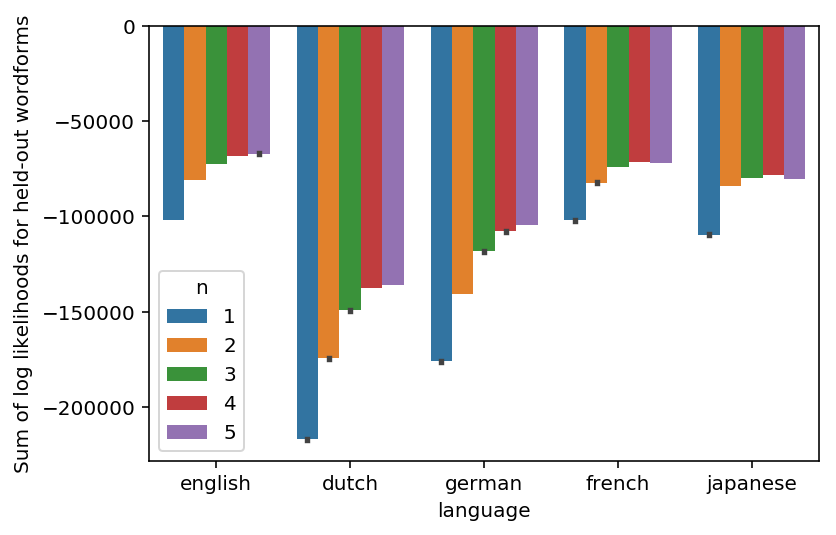

In [130]:
sns.barplot(data = df_results,
           x = 'language',
           y = 'sum_loglik',
           hue = 'n')

plt.ylabel("Sum of log likelihoods for held-out wordforms")

Text(0, 0.5, 'Mean log likelihood for held-out wordforms')

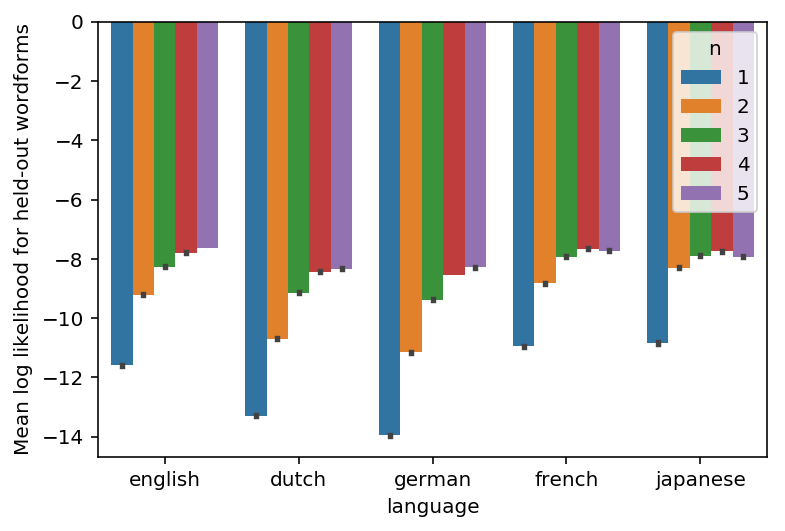

In [131]:
sns.barplot(data = df_results,
           x = 'language',
           y = 'mean_loglik',
           hue = 'n')

plt.ylabel("Mean log likelihood for held-out wordforms")

In [140]:
df_results['n'] = df_results['n'].apply(lambda x: str(x) + "-phone")

Text(0, 0.5, 'Mean log likelihood for held-out wordforms')

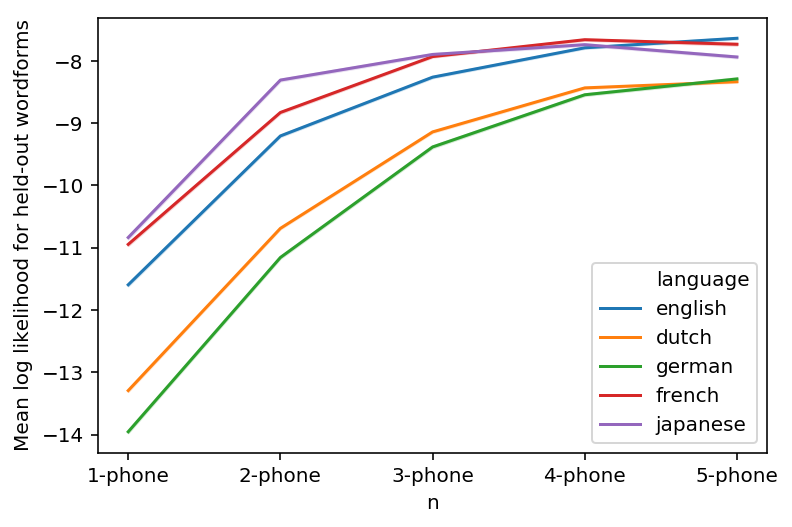

In [145]:
sns.lineplot(data = df_results,
           x = 'n',
           y = 'mean_loglik',
           hue = 'language')

plt.ylabel("Mean log likelihood for held-out wordforms")

Text(0, 0.5, 'Sum log likelihood for held-out wordforms')

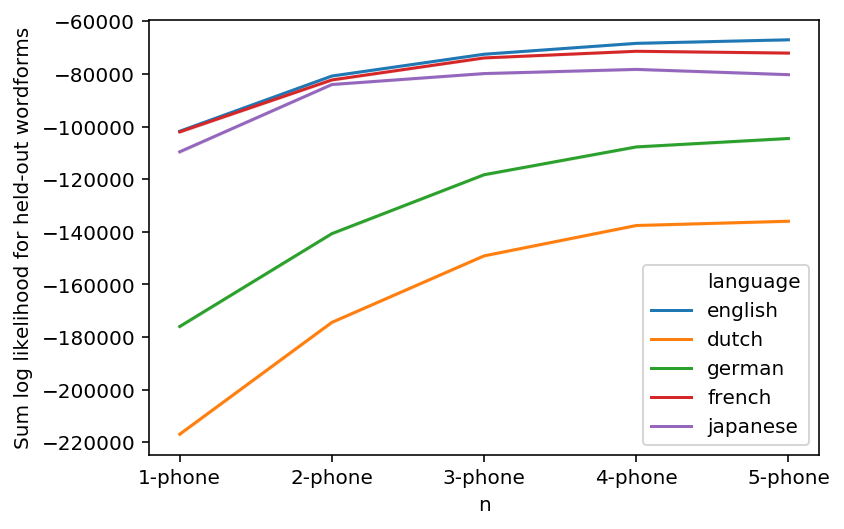

In [147]:
sns.lineplot(data = df_results,
           x = 'n',
           y = 'sum_loglik',
           hue = 'language')

plt.ylabel("Sum log likelihood for held-out wordforms")